In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve

# Load dataset (replace with your file path)
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
print("Dataset Shape:", df.shape)
print("\nFirst 5 Rows:\n", df.head())

Dataset Shape: (7043, 21)

First 5 Rows:
    customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport Stream

Missing Values:
 customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Churn Distribution:
 Churn
No     5174
Yes    1869
Name: count, dtype: int64


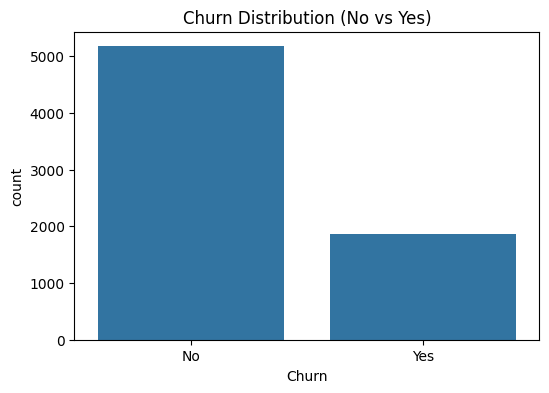

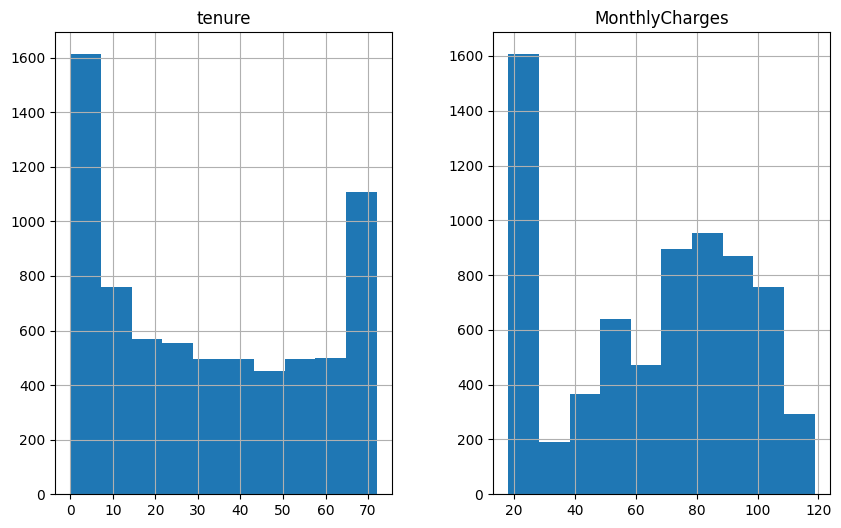

In [7]:
print("Missing Values:\n", df.isnull().sum())

# Check target distribution
print("\nChurn Distribution:\n", df['Churn'].value_counts())

# Visualize churn rate
plt.figure(figsize=(6, 4))
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution (No vs Yes)")
plt.show()

# Numeric features distribution
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
df[numeric_features].hist(figsize=(10, 6))
plt.show()

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

######################################
# DATA LOADING & INITIAL PREPROCESSING
######################################

# Load data (replace with your actual path)
df = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")

# Fix TotalCharges - first convert to numeric properly
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Fill NA values without inplace warning - use proper pandas syntax
median_charges = df['TotalCharges'].median()
df = df.assign(TotalCharges=df['TotalCharges'].fillna(median_charges))

# Check if customerID exists before dropping
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)
else:
    print("customerID column not found - skipping drop")

######################################
# FEATURE ENGINEERING
######################################

# Convert binary features safely
binary_map = {'Yes': 1, 'No': 0}
binary_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for col in binary_cols:
    if col in df.columns:  # Check if column exists
        df[col] = df[col].map(binary_map)
    else:
        print(f"Column {col} not found - skipping")

# Convert gender safely
if 'gender' in df.columns:
    df['gender'] = df['gender'].map({'Male': 1, 'Female': 0})
else:
    print("gender column not found - skipping")

# One-hot encode categorical variables safely
cat_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 
            'OnlineBackup', 'DeviceProtection', 'TechSupport',
            'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod']

# Only encode columns that exist in the dataframe
existing_cat_cols = [col for col in cat_cols if col in df.columns]
df = pd.get_dummies(df, columns=existing_cat_cols, drop_first=True)

######################################
# MODEL TRAINING
######################################

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train logistic regression with class weighting
model = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',  # Handles class imbalance
    solver='liblinear'  # Better for smaller datasets
)
model.fit(X_train_scaled, y_train)

######################################
# EVALUATION
######################################

# Predictions
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Probabilities for class 1

# Metrics
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# Feature importance (coefficients)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
}).sort_values('Coefficient', ascending=False)

print("\nTop 10 Positive Impact Features:")
print(feature_importance.head(10))

print("\nTop 10 Negative Impact Features:")
print(feature_importance.tail(10))

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.72      0.80      1035
           1       0.51      0.78      0.61       374

    accuracy                           0.74      1409
   macro avg       0.70      0.75      0.71      1409
weighted avg       0.80      0.74      0.75      1409


Confusion Matrix:
[[749 286]
 [ 81 293]]

ROC AUC Score: 0.8412

Top 10 Positive Impact Features:
                           Feature  Coefficient
11     InternetService_Fiber optic     0.810878
8                     TotalCharges     0.471756
24             StreamingMovies_Yes     0.286826
22                 StreamingTV_Yes     0.273658
10               MultipleLines_Yes     0.201701
28  PaymentMethod_Electronic check     0.189324
6                 PaperlessBilling     0.164634
18            DeviceProtection_Yes     0.058858
1                    SeniorCitizen     0.056384
5                     PhoneService     0.024852

Top 10 Negative Impact